In [3]:
fldr="UTKFace"

In [4]:
import os
files=os.listdir(fldr)
print(int(files[0].split('_')[0]))
print(files[0])

100
100_0_0_20170112213500903.jpg.chip.jpg


In [5]:
import cv2
ages=[]
genders=[]
images=[]

for i, fle in enumerate(files):
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  total=fldr+'/'+fle
  image=cv2.imread(total)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(48,48))
  images.append(image)

In [6]:
for fle in files:
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  ages.append(age)
  genders.append(gender)

In [7]:
print(ages[24])
print(genders[24])

10
0


In [8]:
print(ages[53])
print(genders[53])

10
0


In [9]:
import numpy as np
images_f=np.array(images)
genders_f=np.array(genders)
ages_f=np.array(ages)

In [10]:
np.save('image.npy',images_f)
np.save('gender.npy',genders_f)
np.save('age.npy',ages_f)

Male = 0
Female= 1

In [11]:
values, counts = np.unique(genders_f, return_counts=True)
print(counts)

[12391 11317]


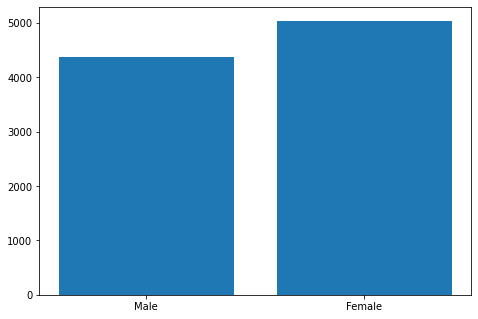

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
gender = ['Male', 'Female']
values=[4372,5047]
ax.bar(gender,values)
plt.show()

In [13]:
values, counts = np.unique(ages_f, return_counts=True)
print(counts)

[1123  482  289  273  196  131  139  263  166  156   65  130   81  157
  177  247  158  262   98  284  346  395  426  859  734 2197  615  918
  570  724  350  664  143  409  880  483  293  325  266  526  132  266
  157  100  440  153  170  153  148  381  138  232  241  353  268  236
   97  271   82  293  161  125  103   50  259   77   94  100   56  147
   33   98   63   32  148   58   28   69   23  133   22   40   18   24
  155   35   10   34   33   82    2   13    5    9   17    9   11    2
    1    5    5    1    3    4]


In [14]:
val=values.tolist()
cnt=counts.tolist()

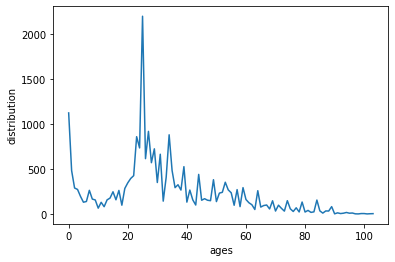

In [15]:
plt.plot(counts)
plt.xlabel('ages')
plt.ylabel('distribution')
plt.show()

In [16]:
labels=[]

i=0
while i<len(ages):
  label=[]
  label.append([ages[i]])
  label.append([genders[i]])
  labels.append(label)
  i+=1

In [17]:
images_f_2=images_f/255
labels_f=np.array(labels)
images_f_2.shape

(23708, 48, 48, 3)

In [18]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, Y_train, Y_test= train_test_split(images_f_2, labels_f,test_size=0.25)

In [20]:
Y_train[0:5]

array([[[25],
        [ 1]],

       [[40],
        [ 0]],

       [[42],
        [ 0]],

       [[39],
        [ 0]],

       [[30],
        [ 1]]])

In [21]:
Y_train_2=[Y_train[:,1],Y_train[:,0]]
Y_test_2=[Y_test[:,1],Y_test[:,0]]

In [22]:
Y_train_2[0][0:5]

array([[1],
       [0],
       [0],
       [0],
       [1]])

In [23]:
Y_train_2[1][0:5]

array([[25],
       [40],
       [42],
       [39],
       [30]])

In [24]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=32,kernel_size=(3, 3),padding = 'same',kernel_regularizer=l2(0.01))(input_tensor)
    x = Dropout(0.2)(x)
    x= Activation('relu')(x)

    return x
def model(input_shape):
  inputs = Input((input_shape))
  
  conv_1= Convolution(inputs,64)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,32)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,64)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,512)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  flatten= Flatten() (maxp_4)
  dense_1= Dense(64,activation='relu')(flatten)
  dense_2= Dense(64,activation='relu')(flatten)
  drop_1=Dropout(0.2)(dense_1)
  drop_2=Dropout(0.2)(dense_2)
  output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
  output_2= Dense(1,activation="relu",name='age_out')(drop_2)
  model = Model(inputs=[inputs], outputs=[output_1,output_2])
  model.compile(loss=["binary_crossentropy","mae"], optimizer="Adam",
	metrics=["accuracy"])
  
  return model

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [26]:
fle_s='model_prediction.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=80, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,Early_stop]

In [31]:
History=Model.fit(X_train,Y_train_2,batch_size=64,validation_data=(X_test,Y_test_2),epochs=30)

Epoch 1/30
278/278 [==============================] - 32s 114ms/step - loss: 6.5967 - sex_out_loss: 0.3187 - age_out_loss: 5.4566 - sex_out_accuracy: 0.8196 - age_out_accuracy: 0.0478 - val_loss: 6.7249 - val_sex_out_loss: 0.2260 - val_age_out_loss: 5.6742 - val_sex_out_accuracy: 0.9040 - val_age_out_accuracy: 0.0461
Epoch 2/30
278/278 [==============================] - 33s 118ms/step - loss: 6.4804 - sex_out_loss: 0.3189 - age_out_loss: 5.3328 - sex_out_accuracy: 0.8236 - age_out_accuracy: 0.0478 - val_loss: 7.0057 - val_sex_out_loss: 0.2330 - val_age_out_loss: 5.9390 - val_sex_out_accuracy: 0.8991 - val_age_out_accuracy: 0.0461
Epoch 3/30
278/278 [==============================] - 33s 117ms/step - loss: 6.4842 - sex_out_loss: 0.3169 - age_out_loss: 5.3288 - sex_out_accuracy: 0.8213 - age_out_accuracy: 0.0478 - val_loss: 7.6548 - val_sex_out_loss: 0.2440 - val_age_out_loss: 6.5685 - val_sex_out_accuracy: 0.9008 - val_age_out_accuracy: 0.0461
Epoch 4/30
278/278 [=======================

In [28]:
from tensorflow.keras.models import load_model
Model = load_model('model_prediction_1.h5')

In [29]:
Model.evaluate(X_test,Y_test_2)

186/186 [==============================] - 2s 12ms/step - loss: 5.8653 - sex_out_loss: 0.2147 - age_out_loss: 4.8642 - sex_out_accuracy: 0.9077 - age_out_accuracy: 0.0461


[5.865315914154053,
 0.2146730273962021,
 4.864241600036621,
 0.9077104926109314,
 0.04606040194630623]

In [32]:
pred=Model.predict(X_test)

186/186 [==============================] - 2s 11ms/step


In [33]:
pred[1]

array([[27.438976 ],
       [42.178577 ],
       [ 1.7762253],
       ...,
       [21.949581 ],
       [32.890648 ],
       [28.477737 ]], dtype=float32)

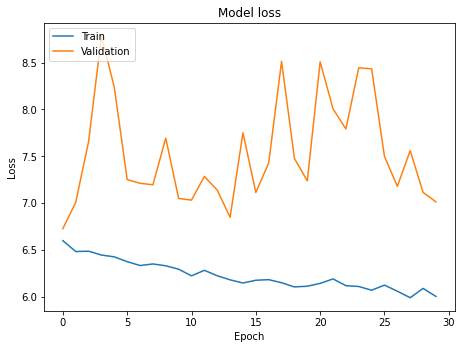

In [34]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

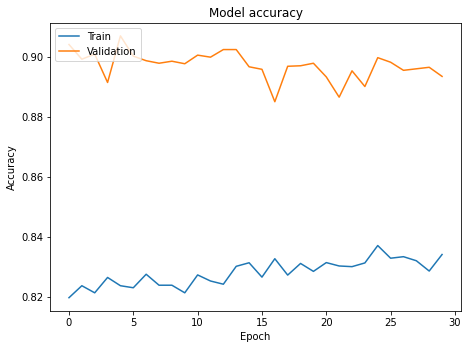

In [35]:
plt.plot(History.history['sex_out_accuracy'])
plt.plot(History.history['val_sex_out_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

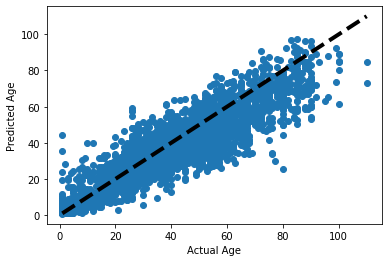

In [36]:
fig, ax = plt.subplots()
ax.scatter(Y_test_2[1], pred[1])
ax.plot([Y_test_2[1].min(),Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

In [37]:
i=0
Pred_l=[]
while(i<len(pred[0])):

  Pred_l.append(int(np.round(pred[0][i])))
  i+=1


In [38]:
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import classification_report 

In [39]:

report=classification_report(Y_test_2[0], Pred_l)

In [40]:
print(report)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3118
           1       0.89      0.88      0.89      2809

    accuracy                           0.89      5927
   macro avg       0.89      0.89      0.89      5927
weighted avg       0.89      0.89      0.89      5927



In [41]:

results = confusion_matrix(Y_test_2[0], Pred_l)

<AxesSubplot:>

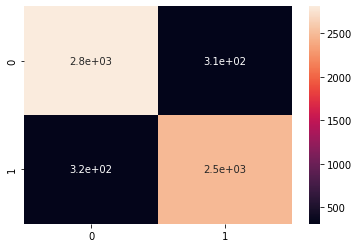

In [42]:
import seaborn as sns

sns.heatmap(results, annot=True)

In [55]:
def test_image(ind,images_f,images_f_2,Model):
#   cv2_imshow(images_f[ind])
  plt.imshow(images_f[ind])
  image_test=images_f_2[ind]
  pred_1=Model.predict(np.array([image_test]))
  #print(pred_1)
  sex_f=['Male','Female']
  age=int(np.round(pred_1[1][0]))
  sex=int(np.round(pred_1[0][0]))
  print("Predicted Age: "+ str(age))
  print("Predicted Sex: "+ sex_f[sex])


In [44]:
img = cv2.imread('.jpg')
img = cv2.resize(img,(48,48))
img = np.reshape(img,[48,48,3])

1/1 [==============================] - 0s 14ms/step
Predicted Age: 9
Predicted Sex: Female


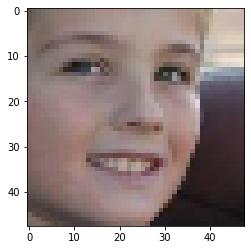

In [56]:
test_image(57,images_f,images_f_2,Model)

1/1 [==============================] - 0s 14ms/step
Predicted Age: 8
Predicted Sex: Female


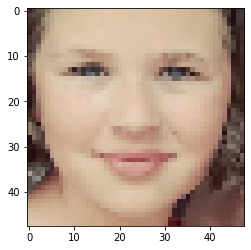

In [52]:
test_image(137,images_f,images_f_2,Model)

1/1 [==============================] - 0s 12ms/step
Predicted Age: 14
Predicted Sex: Male


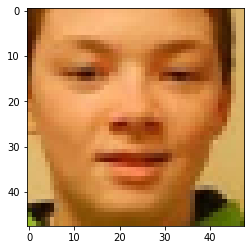

In [53]:
test_image(502,images_f,images_f_2,Model)

1/1 [==============================] - 0s 14ms/step
Predicted Age: 7
Predicted Sex: Female


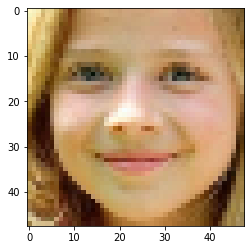

In [60]:
test_image(134,images_f,images_f_2,Model)

1/1 [==============================] - 0s 14ms/step
Predicted Age: 26
Predicted Sex: Female


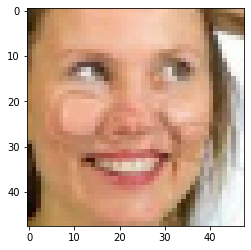

In [66]:
test_image(12334,images_f,images_f_2,Model)

1/1 [==============================] - 0s 13ms/step
Predicted Age: 26
Predicted Sex: Male


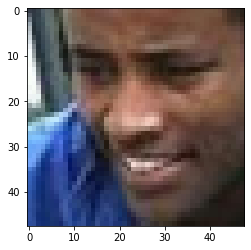

In [67]:
test_image(11334,images_f,images_f_2,Model)

1/1 [==============================] - 0s 13ms/step
Predicted Age: 49
Predicted Sex: Female


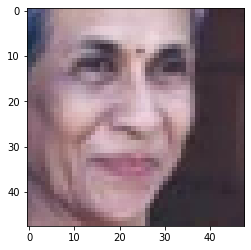

In [68]:
test_image(21334,images_f,images_f_2,Model)

1/1 [==============================] - 0s 13ms/step
Predicted Age: 77
Predicted Sex: Male


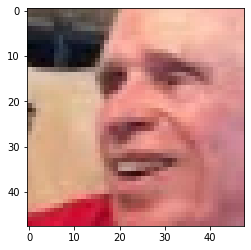

In [71]:
test_image(22334,images_f,images_f_2,Model)

1/1 [==============================] - 0s 13ms/step
Predicted Age: 55
Predicted Sex: Male


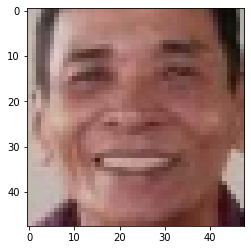

In [72]:
test_image(19334,images_f,images_f_2,Model)